# Time Series Analysis and Forecasting

This is a series of notebooks to support lectures on _Time series analysis and forecast_.

![](https://user-images.githubusercontent.com/49638680/154160268-cf39a1ec-3557-4940-8853-d06fc7a79acf.png)

## Time series Operations

In paticular, over this notebook we are going to explore various operations we can apply to time series. We have all the tools for upsamplig, rolling methods, and of course to visualise results.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

import statsmodels.api as sm

%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.rcParams['figure.figsize'] = (15.0, 10.0)
sns.set()

In [2]:
url_data = "https://raw.githubusercontent.com/fbagattini/Lezioni/master/data/OPSD_Germany_all.csv"

##### Import data and indexing them at loading time
Recall that we can make all the operations in one line of code. We will use some selected arguments of `read_csv`:

* `parse_dates` 
* `index_col`

The former one accepts a boolean as value (hence`True` or `False`) setting whether to try parsing dates as `Datetime` objects, on the other hand the latter accepts a string or a list of strings indicating which columns should be used as index.

In [3]:
df = pd.read_csv(url_data,
                 parse_dates=True,
                 index_col='Date')
df.head()

,Consumption,Wind,Solar
Date,,,
2006-01-01,1069.184,NaN,NaN
2006-01-02,1380.521,NaN,NaN
2006-01-03,1442.533,NaN,NaN
2006-01-04,1457.217,NaN,NaN
2006-01-05,1477.131,NaN,NaN


##### Visualise data

It is important to visualise data just to look at them and have an idea of the needed operations.
We are going to plot with a _line plot_, one per column and finally one with all our variables on the same graph.

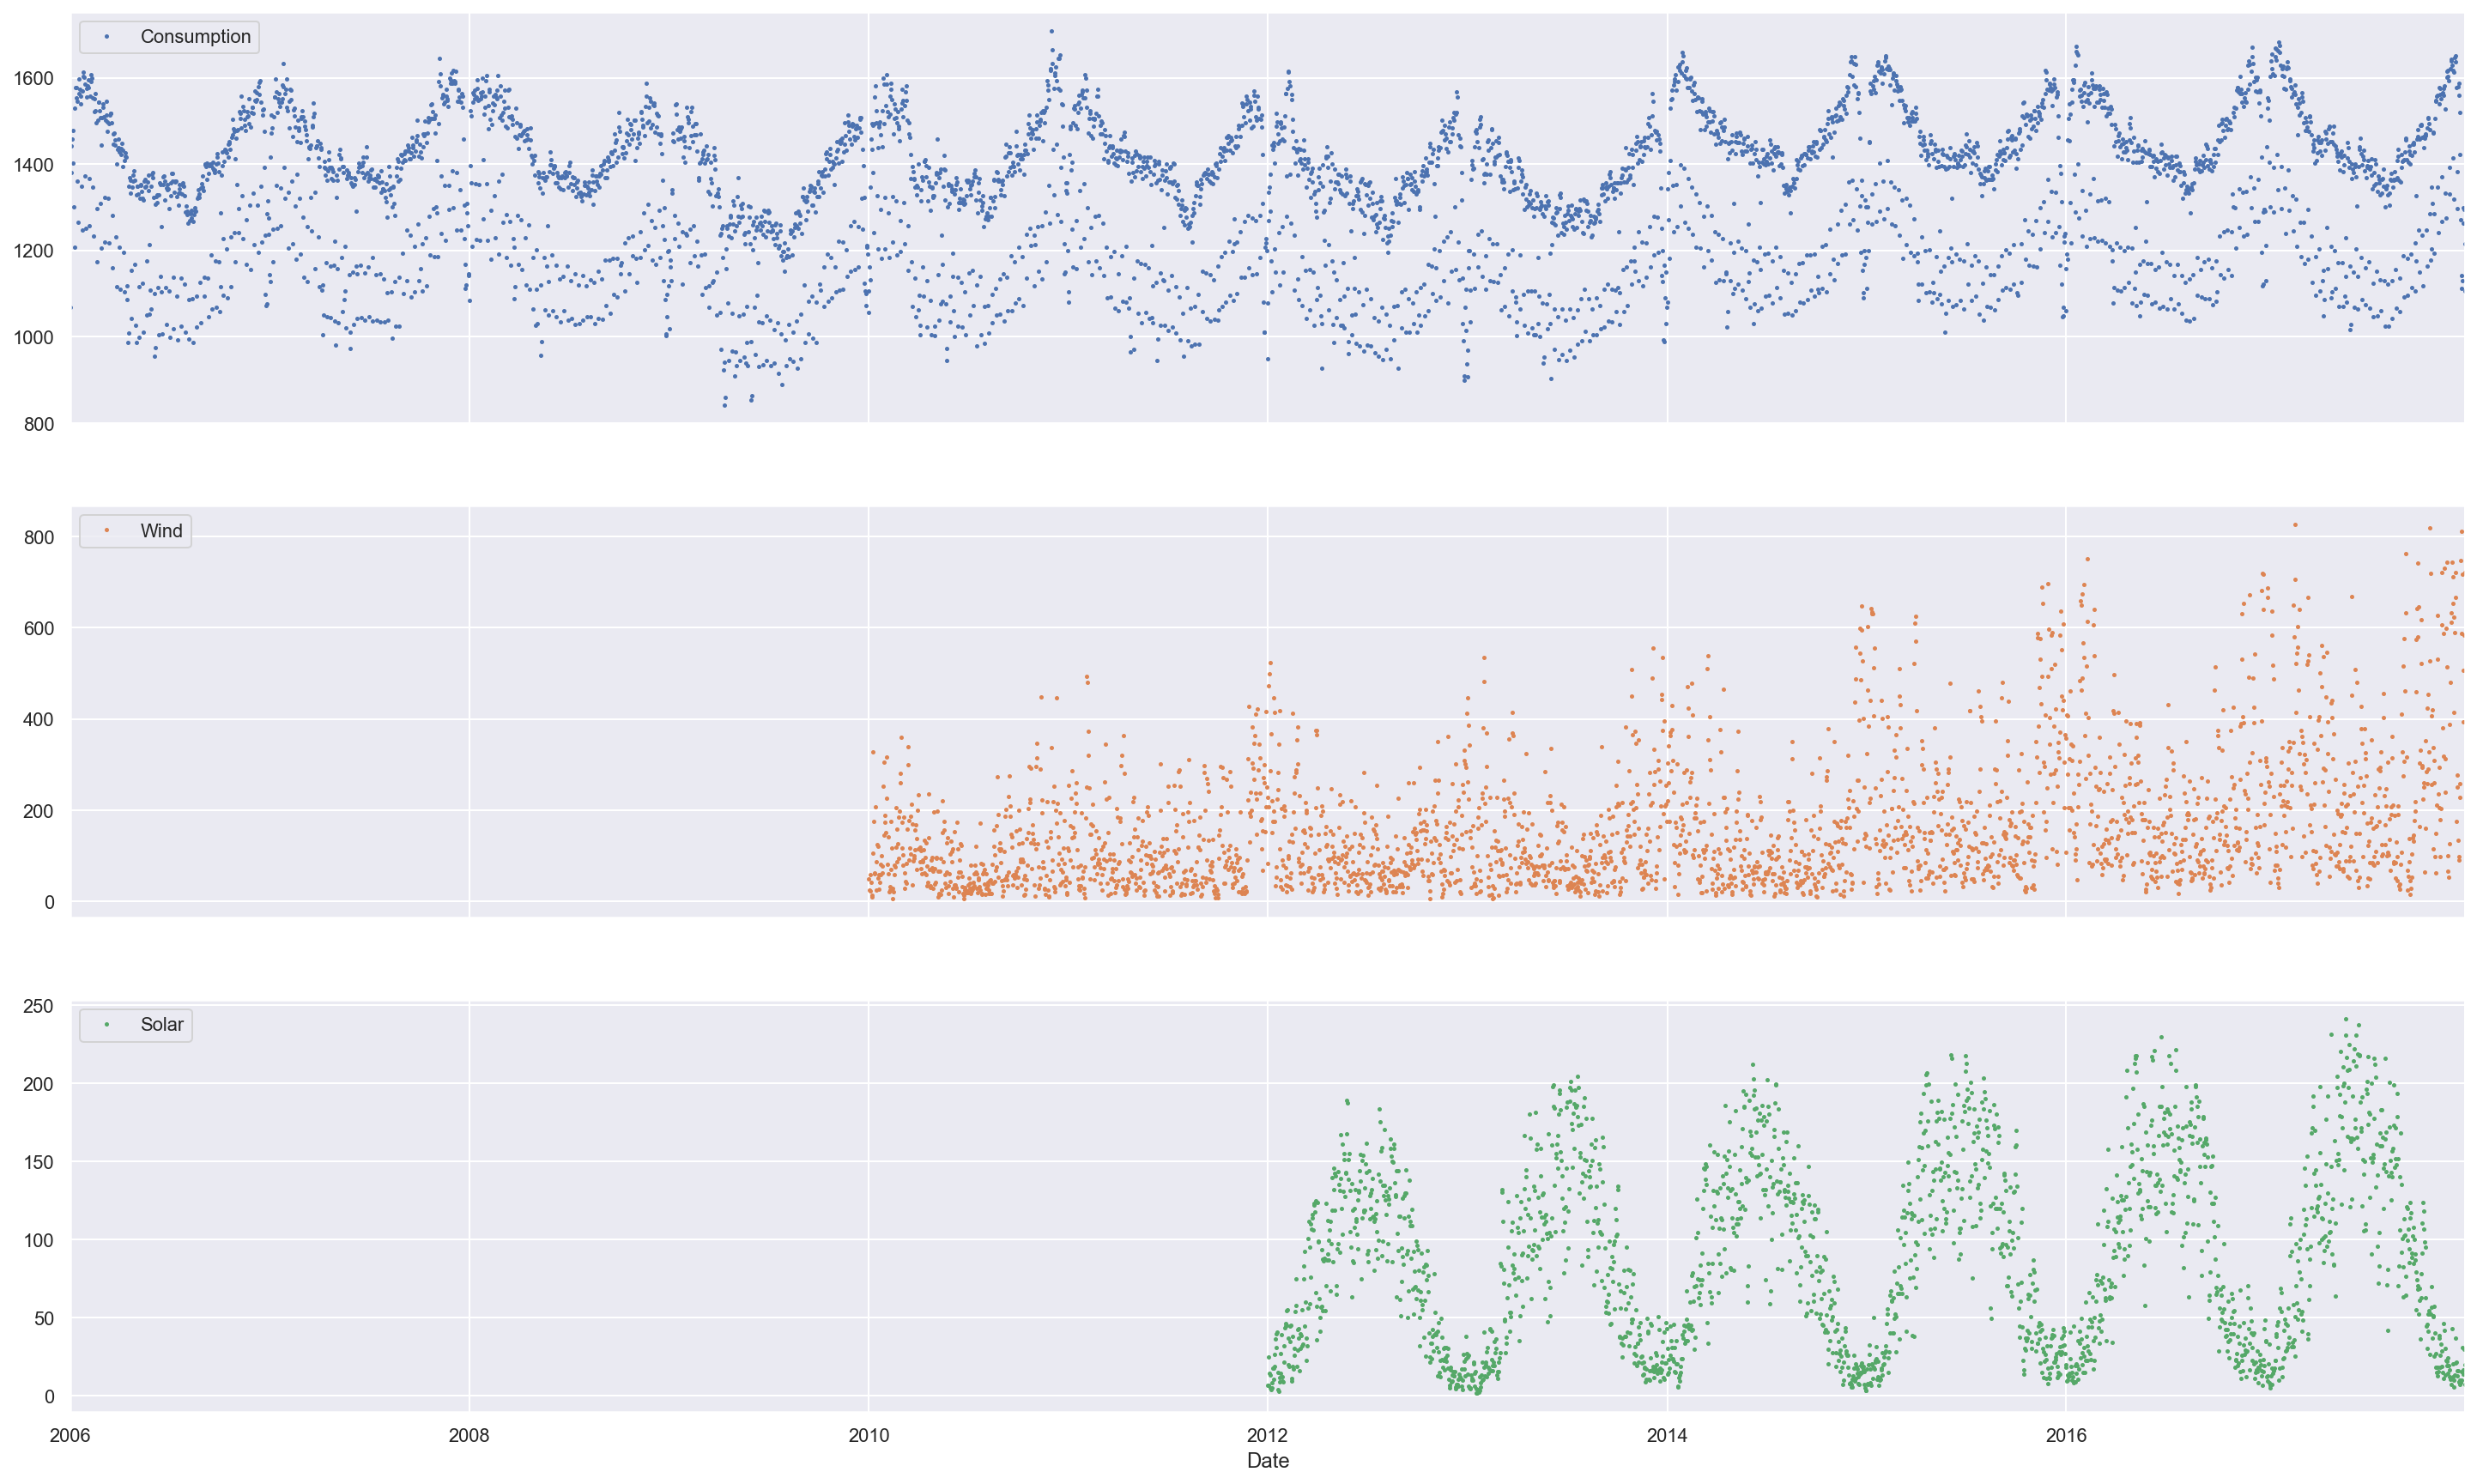

In [5]:
subplots = df.plot(figsize=(25, 15),
                   marker='.',
                   markersize=3,
                   linestyle='',
                   subplots=True)

subplots;

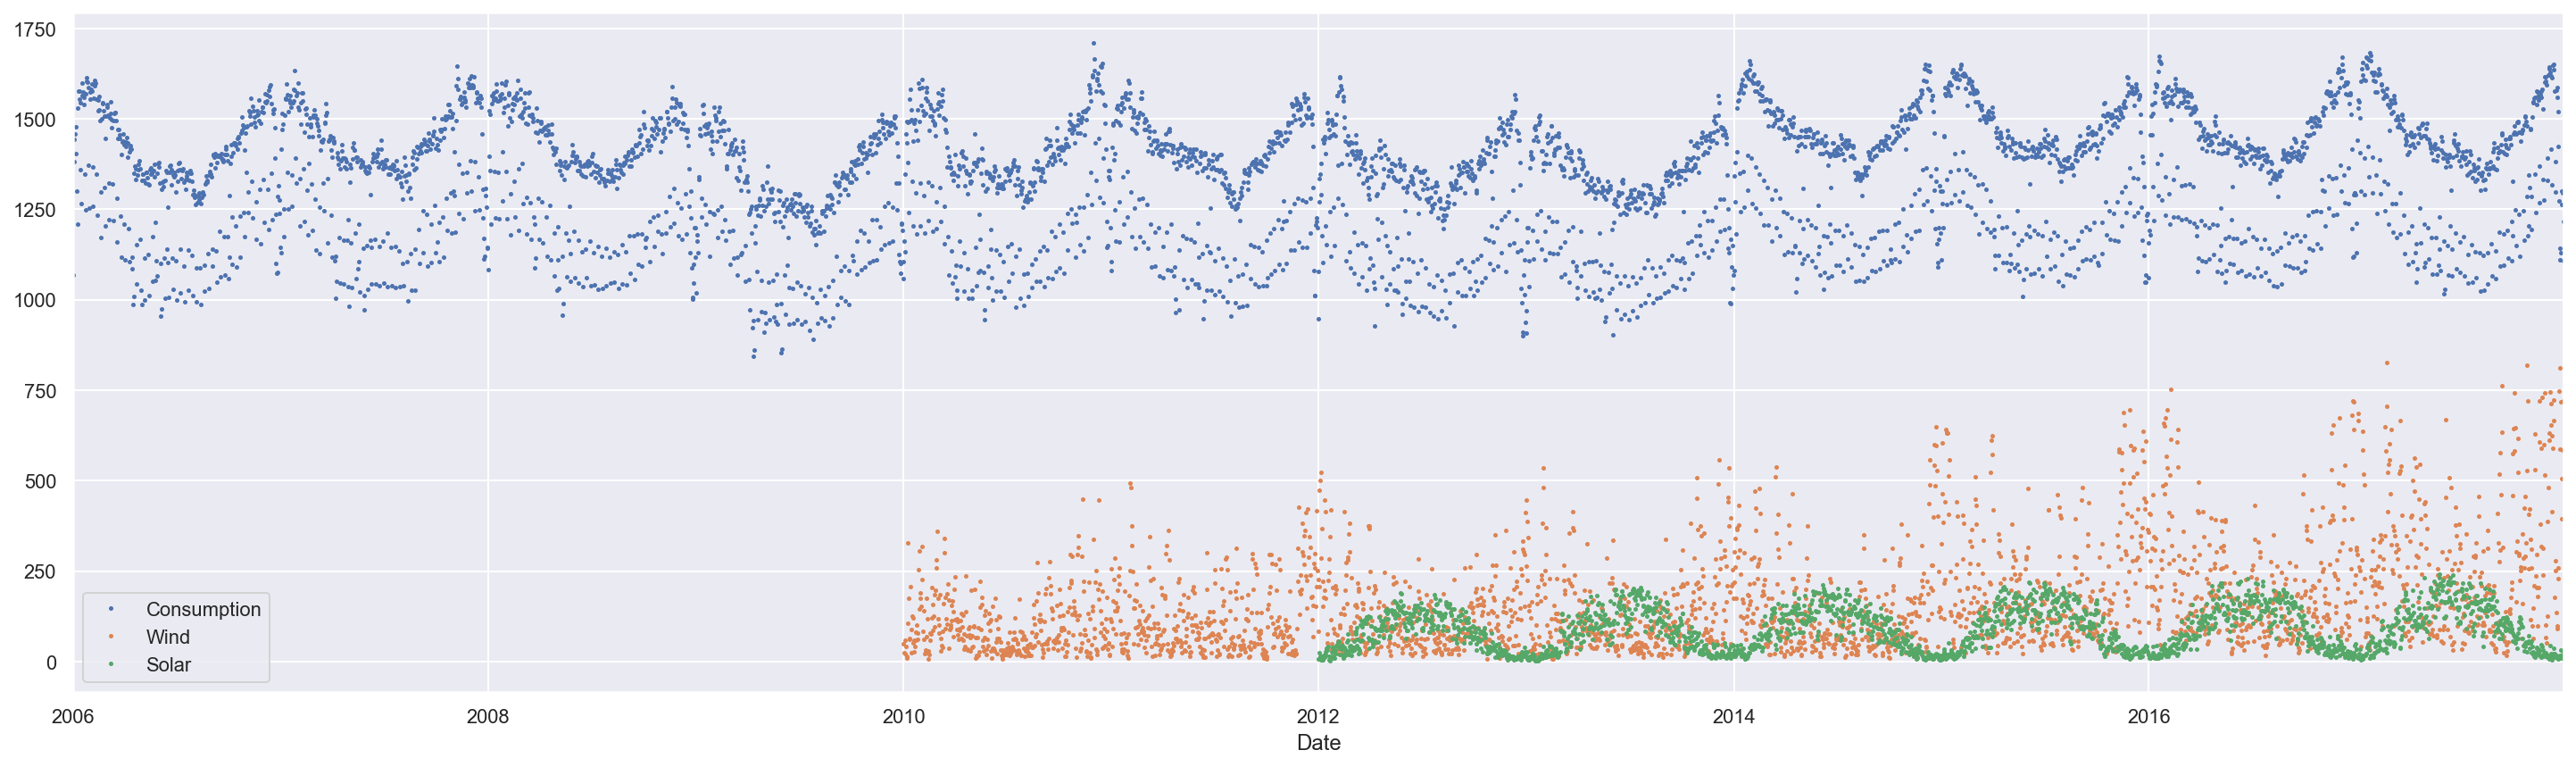

In [7]:
df.plot(figsize=(25, 7),
                   marker='.',
                   markersize=3,
                   linestyle='');

The last plot shows with great clarity the different scales that are involved.

### Resampling

When we sample a time series with a frequency lower than the original, we are _downsampling_. To perform this operation we need an aggregation function (median, mean, max, etc.).
Conversely, by increasing the sample frequency we are _upsampling_. 
What do we need in this case? We have alredy seen how to fill holes in frequency.

For the moment being, let's add a new piece of information to our dataset: the weeday.

In [8]:
df['Weekday'] = df.index.day_name()

df.head()

,Consumption,Wind,Solar,Weekday
Date,,,,
2006-01-01,1069.184,NaN,NaN,Sunday
2006-01-02,1380.521,NaN,NaN,Monday
2006-01-03,1442.533,NaN,NaN,Tuesday
2006-01-04,1457.217,NaN,NaN,Wednesday
2006-01-05,1477.131,NaN,NaN,Thursday


Downsampling is another effective tool for inspecting the seasonality of a time series. Let's start by computing the average weekly consumption of 2013.

In [9]:
df[['Consumption', 'Weekday']].loc['2013'].head(15)

,Consumption,Weekday
Date,,
2013-01-01,906.910,Tuesday
2013-01-02,1160.174,Wednesday
2013-01-03,1199.565,Thursday
2013-01-04,1198.952,Friday
2013-01-05,1108.271,Saturday
2013-01-06,1035.316,Sunday
2013-01-07,1364.084,Monday
2013-01-08,1397.750,Tuesday
2013-01-09,1408.435,Wednesday


For the first week,

In [12]:
df[['Consumption', 'Weekday']].loc['2013'][:7]

,Consumption,Weekday
Date,,
2013-01-01,906.910,Tuesday
2013-01-02,1160.174,Wednesday
2013-01-03,1199.565,Thursday
2013-01-04,1198.952,Friday
2013-01-05,1108.271,Saturday
2013-01-06,1035.316,Sunday
2013-01-07,1364.084,Monday


In [13]:
df['Consumption']['2013'][:7].mean()

1139.038857142857

Let's take the first "complete" week (from Monday to Sunday) of the year:

In [14]:
df[['Consumption', 'Weekday']].loc['2013'][6:13]

,Consumption,Weekday
Date,,
2013-01-07,1364.084,Monday
2013-01-08,1397.750,Tuesday
2013-01-09,1408.435,Wednesday
2013-01-10,1388.447,Thursday
2013-01-11,1390.838,Friday
2013-01-12,1192.418,Saturday
2013-01-13,1112.380,Sunday


We can calculate the mean as

In [16]:
df['Consumption']['2013'][6:13].mean()

1322.0502857142856

This very same result can be obtained through a pandas method called `resample`. Pandas provides [shortcuts](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases) (_aliases_) for several resampling frequencies.

In [19]:
df['Consumption']['2013'].resample(rule = 'W')

As you can see, we get a `DatetimeIndexResampler object`. Indeed, the resample method alone is not enough: we need an _aggregation_ function.

In [21]:
df['Consumption']['2013'].resample('W-MON').mean().head()

Date
2013-01-07    1139.038857
2013-01-14    1333.075000
2013-01-21    1388.046286
2013-01-28    1398.602286
2013-02-04    1314.209857
Freq: W-MON, Name: Consumption, dtype: float64

The `label` arguments allows to choose which endpoint (`left` or `right`) is assigned to the resampling window.

In [22]:
df['Consumption']['2013'].resample(rule ='W-MON', label = 'left').mean().head()

Date
2012-12-31    1139.038857
2013-01-07    1333.075000
2013-01-14    1388.046286
2013-01-21    1398.602286
2013-01-28    1314.209857
Freq: W-MON, Name: Consumption, dtype: float64

Note the initial date.

By default, the right endpoint is included, while the left one is not. Such behaviour can be changed with the `closed` (boolean) argument.

Let's build a new dataframe and plot it alongside with the original one.

In [23]:
df_consumption_2013_weekly = df['Consumption']['2013'].resample('W-MON').mean()

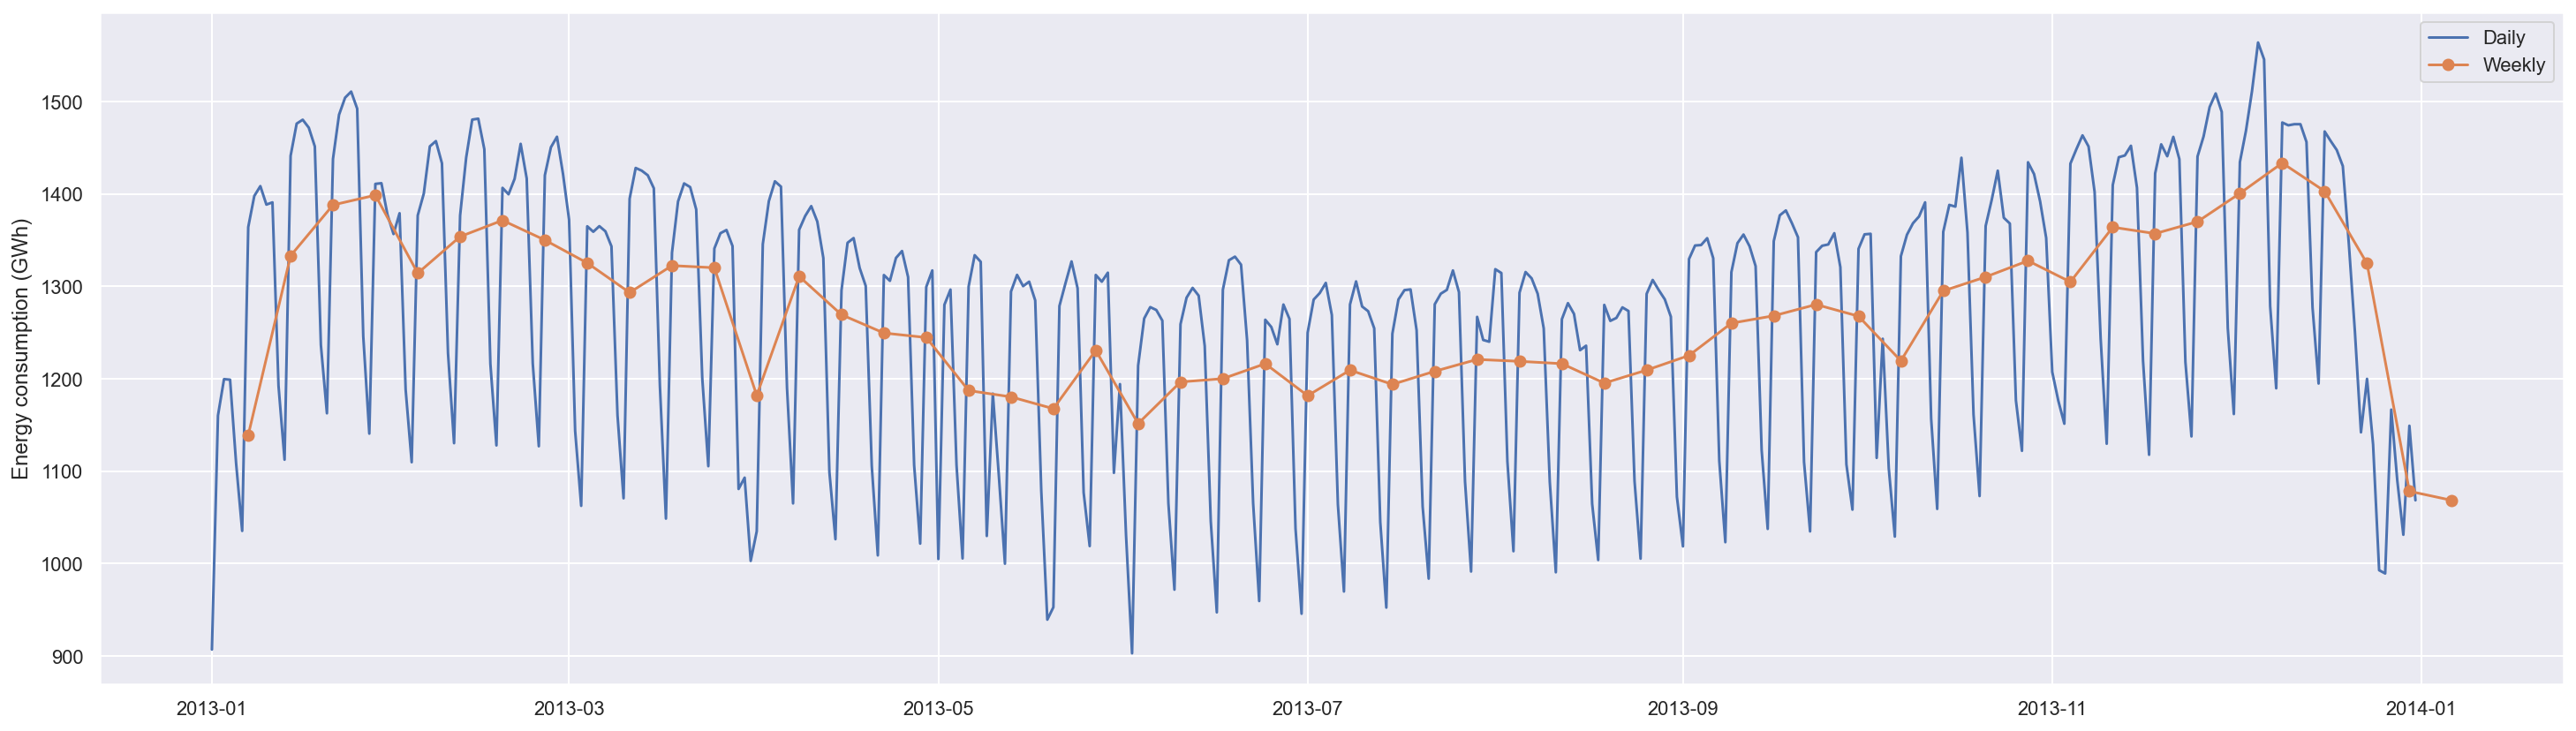

In [25]:
plt.figure(figsize=(25,7))

plt.plot(df['Consumption']['2013'], label='Daily')

plt.plot(df_consumption_2013_weekly,
         marker='o',
         label='Weekly')

plt.ylabel('Energy consumption (GWh)')
plt.legend();

##### Question

> What effect have we gotten by weekly downsampling?

---
### Exercise 1

Compare (within a single plot) the monthly trends of

* electric energy consumption
* renewable energy production (solar, wind and the sum of the two).

Plot the yearly trend of the ratio between

* renewable energy production
* electric energy consumption.

---

### Rolling windows

The `rolling` function is another useful Pandas tool. As with resample, an aggregation function is required.

Let's suppose we want to analyse energy consumption records within a three-day window.

In [26]:
df['Consumption']

Date
2006-01-01    1069.18400
2006-01-02    1380.52100
2006-01-03    1442.53300
2006-01-04    1457.21700
2006-01-05    1477.13100
                 ...    
2017-12-27    1263.94091
2017-12-28    1299.86398
2017-12-29    1295.08753
2017-12-30    1215.44897
2017-12-31    1107.11488
Name: Consumption, Length: 4383, dtype: float64

Explicitly we could start taking a 3-days-long window and apply it on the _index_, having the rows of the dataframe appearing.

In [27]:
df['Consumption'][:1]

Date
2006-01-01    1069.184
Name: Consumption, dtype: float64

In [29]:
df['Consumption'][:2]

Date
2006-01-01    1069.184
2006-01-02    1380.521
Name: Consumption, dtype: float64

At this point, the window overlaps with the first three records.

In [30]:
df['Consumption'][:3]

Date
2006-01-01    1069.184
2006-01-02    1380.521
2006-01-03    1442.533
Name: Consumption, dtype: float64

And we keep going with a window taking data from row $i-th$ to row $(i+3)-th$.
This is easily implemented through slicing.

In [32]:
df['Consumption'][1:4]

Date
2006-01-02    1380.521
2006-01-03    1442.533
2006-01-04    1457.217
Name: Consumption, dtype: float64

Or in general

In [33]:
k = 24
df['Consumption'][k:k+3]

Date
2006-01-25    1613.312
2006-01-26    1601.673
2006-01-27    1586.065
Name: Consumption, dtype: float64

Let's now aggregate, at each step, all the records lying in the window. For example, we can sum them up.

In [34]:
df['Consumption'][:1].sum()

1069.1840000000002

In [36]:
df['Consumption'][:2].sum()

2449.705000000001

In [37]:
df['Consumption'][:3].sum()

3892.2380000000007

In [38]:
df['Consumption'][1:4].sum()

4280.271000000001

In [39]:
k = 24
df['Consumption'][k:k+3].sum()

4801.049999999998

Of course this is quite involute, we want something more compact.

Precisely, once the width of the sampling window and the aggregation function have been choosen, `rolling` allows to perform the above operation compactly.

In [40]:
df['Consumption'].rolling('3D').sum()

Date
2006-01-01    1069.18400
2006-01-02    2449.70500
2006-01-03    3892.23800
2006-01-04    4280.27100
2006-01-05    4376.88100
                 ...    
2017-12-27    3505.34112
2017-12-28    3693.92172
2017-12-29    3858.89242
2017-12-30    3810.40048
2017-12-31    3617.65138
Name: Consumption, Length: 4383, dtype: float64

The width of the window can be also specified through the number of records it should be containing at each step.

In [41]:
df['Consumption'].rolling(3).sum()

Date
2006-01-01           NaN
2006-01-02           NaN
2006-01-03    3892.23800
2006-01-04    4280.27100
2006-01-05    4376.88100
                 ...    
2017-12-27    3505.34112
2017-12-28    3693.92172
2017-12-29    3858.89242
2017-12-30    3810.40048
2017-12-31    3617.65138
Name: Consumption, Length: 4383, dtype: float64

Note that, doing this, however, the window discards (by default) all the groups with at least one missing value. Of course, we can alter this behaviour by means of optional arguments.

In [42]:
df['Consumption'].rolling(3, min_periods=1).sum()

Date
2006-01-01    1069.18400
2006-01-02    2449.70500
2006-01-03    3892.23800
2006-01-04    4280.27100
2006-01-05    4376.88100
                 ...    
2017-12-27    3505.34112
2017-12-28    3693.92172
2017-12-29    3858.89242
2017-12-30    3810.40048
2017-12-31    3617.65138
Name: Consumption, Length: 4383, dtype: float64

In the following some more example.

In [45]:
df['Consumption'].rolling(3, center=True).sum()

Date
2006-01-01           NaN
2006-01-02    3892.23800
2006-01-03    4280.27100
2006-01-04    4376.88100
2006-01-05    4337.77500
                 ...    
2017-12-27    3693.92172
2017-12-28    3858.89242
2017-12-29    3810.40048
2017-12-30    3617.65138
2017-12-31           NaN
Name: Consumption, Length: 4383, dtype: float64

The `center` argument defines the behaviour of `rolling` in the following way.

* If `False`, set the window labels as the right edge of the window index.
* If `True`, set the window labels as the center of the window index.

Hence, the first window 3-days wide has non-empty value when is set to index $2$ (third position) covering indices `[1:4]`.

Compare with the result of 
```python
df['Consumption'].rolling(3).sum()
``` 
which is the same as 
```python
df['Consumption'].rolling(3, center = False).sum()
```

Let's now have a look at the graphical result yield by rolling. For the sake of convenience, we always set the Matplotlib figsize property once and for all at the import time.

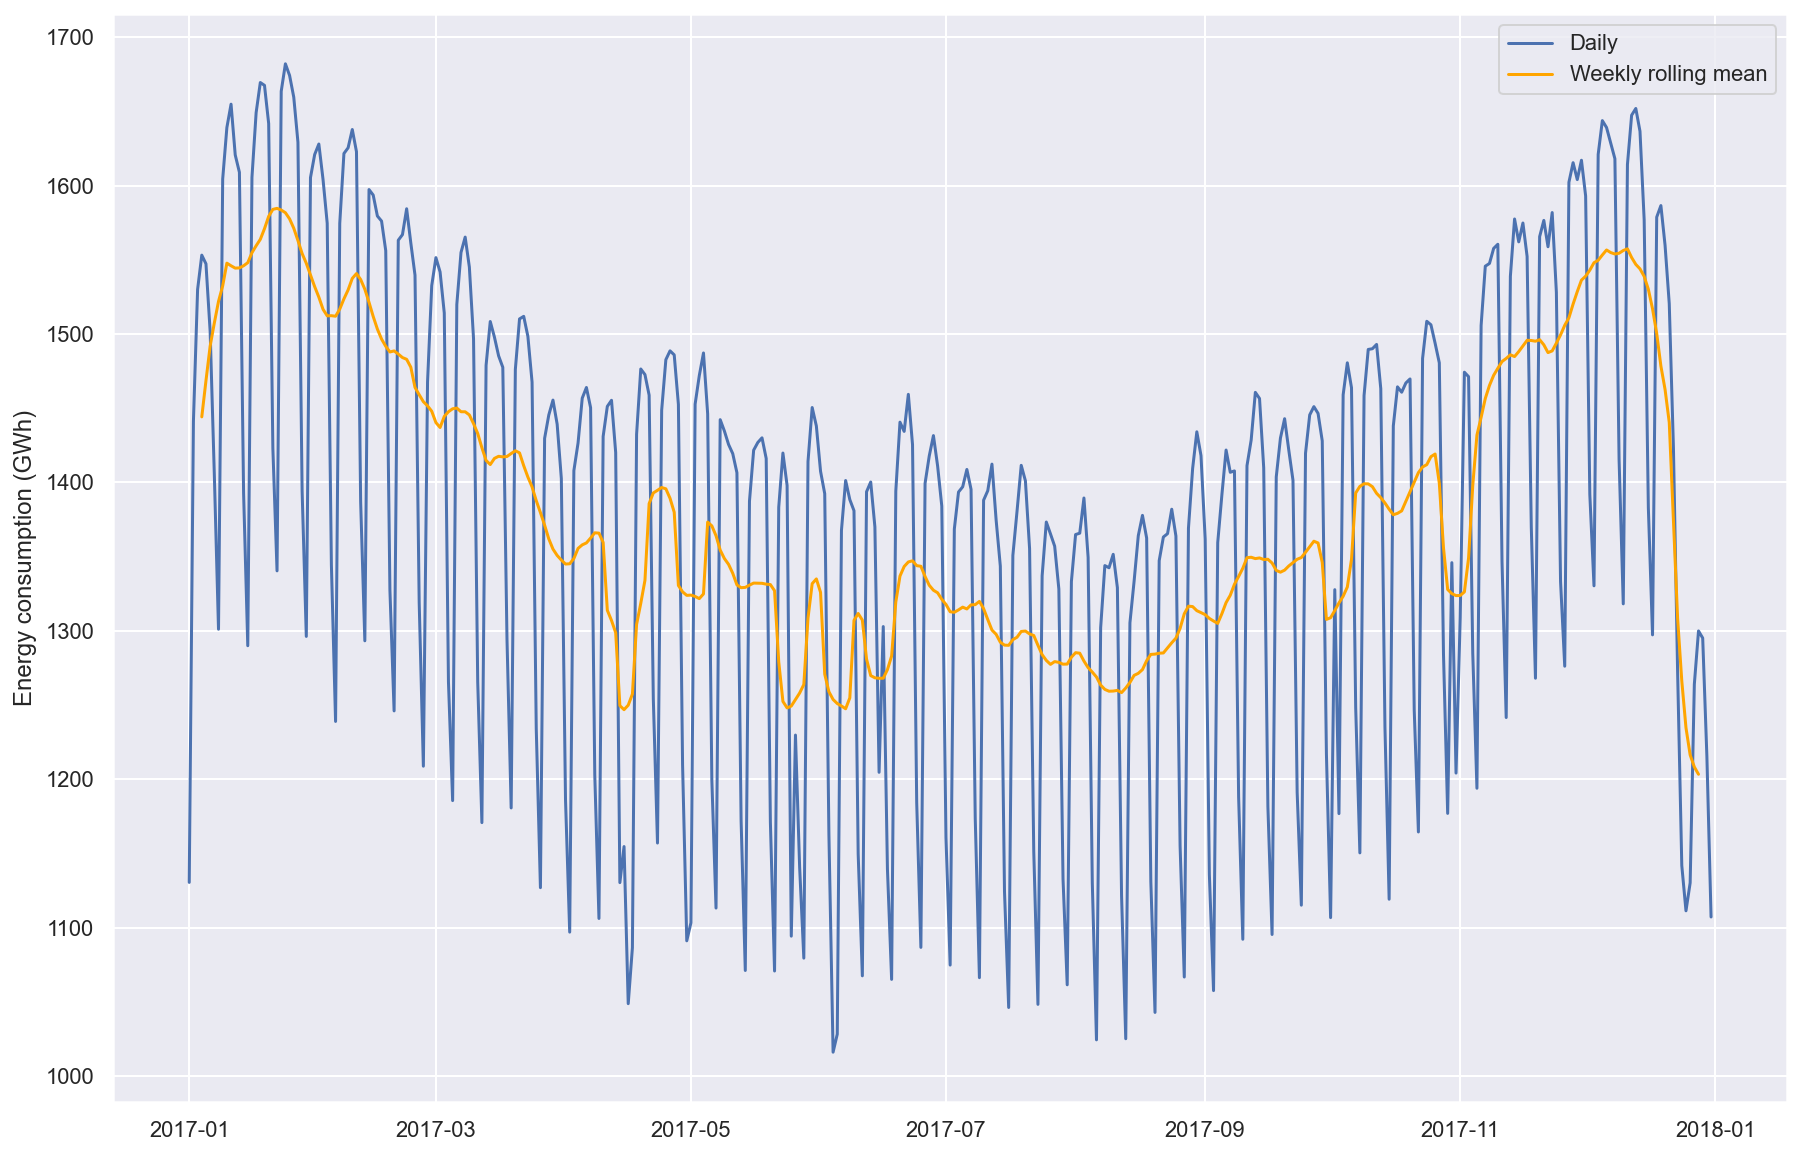

In [47]:
plt.plot(df['Consumption']['2017'],
         label='Daily')

plt.plot(df['Consumption']['2017'].rolling(7, center=True).mean(),
         label='Weekly rolling mean',
         color='orange')

plt.ylabel('Energy consumption (GWh)')
plt.legend();

What if I want the `max` of energy consumption over the window?

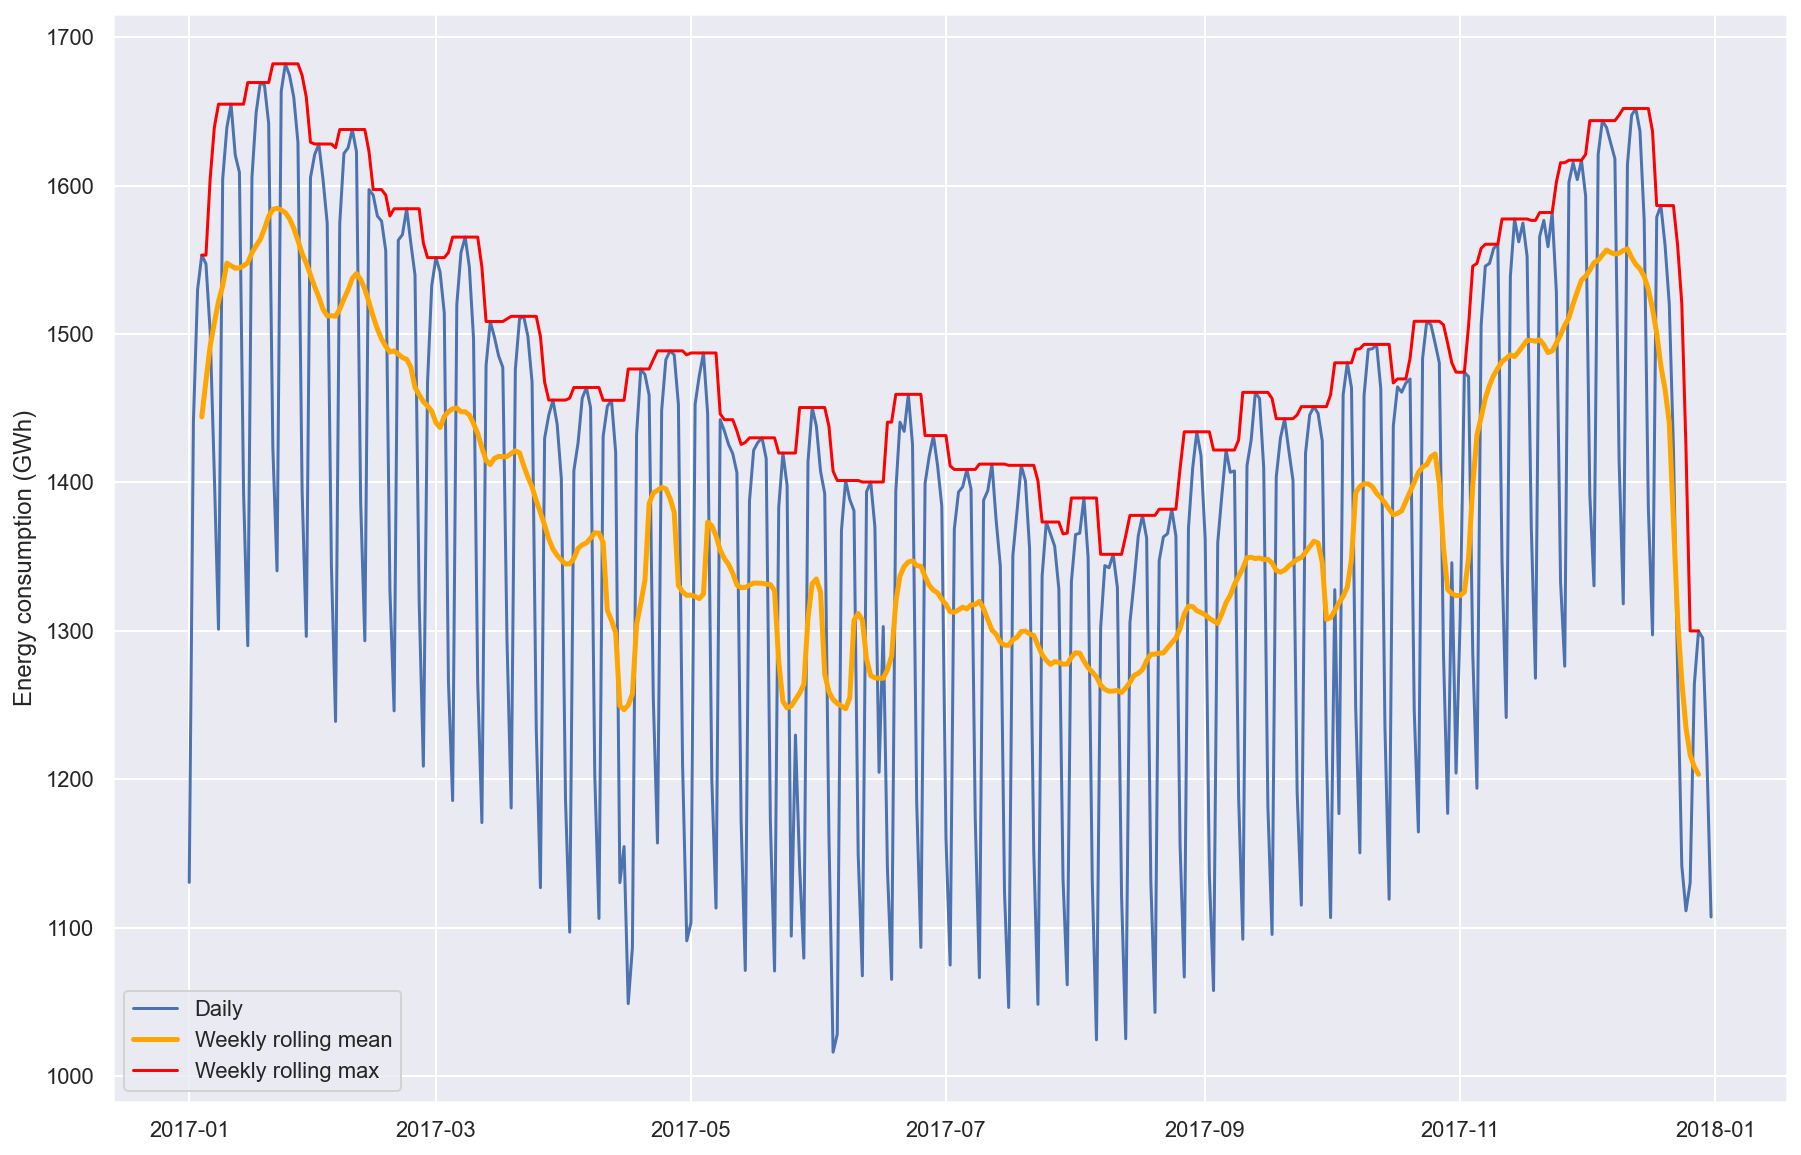

In [52]:
plt.plot(df['Consumption']['2017'],
         label='Daily')

plt.plot(df['Consumption']['2017'].rolling(7, center=True).mean(),
         label='Weekly rolling mean',
         color='orange',
         linewidth=2.5)

plt.plot(df['Consumption']['2017'].rolling(7, center=True).max(),
         label='Weekly rolling max',
         color='red')

plt.ylabel('Energy consumption (GWh)')
plt.legend();

We have computed and represented the $2017$ weekly rolling mean of our consumption data.

---
### Exercise 2

`resample` and `rolling` have common ground. 
How are their outcomes different?

Plot weekly solar energy production during $2017$ from January to July by using resample and rolling. Compare the graphical results.

---

**Recap**: downsampling and rolling windows yield a _smoothing_ effect on a time series. Specifically, variations happening at a frequency lower or equal to the width of the sampling window are canceled out.

Eliminating such seasonal variations allows to focus on another main component of a time series: its **trend**.